In [ ]:
!pip install -q pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Import all necssary libraries
import pandas as pd
import numpy as np
import os
import pretty_midi
import tensorflow as tf
import mido
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



print(tf.__version__)

2.17.0


In [ ]:
!git clone https://huggingface.co/datasets/drengskapur/midi-classical-music

Cloning into 'midi-classical-music'...
remote: Enumerating objects: 5540, done.
remote: Counting objects: 100% (5540/5540), done.
remote: Compressing objects: 100% (4997/4997), done.
remote: Total 5540 (delta 515), reused 5540 (delta 515), pack-reused 0 (from 0)
Receiving objects: 100% (5540/5540), 32.21 MiB | 6.50 MiB/s, done.
Resolving deltas: 100% (515/515), done.
Updating files: 100% (4799/4799), done.


In [ ]:
df = pd.read_csv("midi-classical-music/metadata.csv")
df['file_name'] = "midi-classical-music/" + df['file_name']
df.head()

,file_name
0,midi-classical-music/data/albeniz-aragon_fanta...
1,midi-classical-music/data/albeniz-castilla_seg...
2,midi-classical-music/data/albeniz-cataluna_cou...
3,midi-classical-music/data/albeniz-cataluna_cou...
4,midi-classical-music/data/albeniz-espana_op_16...


In [ ]:
def extract_midi_features(midi_file):
    # Load MIDI file
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except Exception as e:
        print(f"Exception: {e}, Skipping file {midi_file}")
        # skipped_files.append(midi_file)
        return None

    # Initialize feature dictionary
    features = {
        'file_name': midi_file,
        'num_notes': 0,
        'avg_pitch': 0.0,
        'avg_duration': 0.0,
        'avg_velocity': 0.0,
        'tempo': 0.0,
        'time_signature': None,
        'key_signature': None
    }

    # Extract tempo
    if midi_data.get_tempo_changes()[0].size > 0:
        features['tempo'] = midi_data.get_tempo_changes()[1][0]

    # Extract note information
    note_durations = []
    velocities = []
    pitches = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)
            note_durations.append(note.end - note.start)
            velocities.append(note.velocity)

    features['num_notes'] = len(pitches)

    if pitches:
        features['avg_pitch'] = sum(pitches) / len(pitches)
    if note_durations:
        features['avg_duration'] = sum(note_durations) / len(note_durations)
    if velocities:
        features['avg_velocity'] = sum(velocities) / len(velocities)

    # Extract time signature (only the first time signature is used here)
    if midi_data.time_signature_changes:
        features['time_signature'] = midi_data.time_signature_changes[0].numerator


    # Extract key signature (only the first key signature is used here)
    if midi_data.key_signature_changes:
        features['key_signature'] = midi_data.key_signature_changes

    #frames per second
    fs = 100
    piano_roll = midi_data.get_piano_roll(fs=fs)
    piano_roll_simplified = np.sum(piano_roll, axis=1)
    features['piano_roll'] = piano_roll_simplified

    return features

# List of MIDI files (adjust this to your file paths)
midi_files = df

artists = ['bach', 'beethoven', 'chopin', 'mozart']
# Extract features for each file
data = []
for midi_file in midi_files['file_name']:
    if any(artist in midi_file for artist in artists):
        features = extract_midi_features(midi_file)
        data.append(features)
        continue

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Exception: Could not decode key with 3 flats and mode 255, Skipping file midi-classical-music/data/beethoven-anhang_14_3.mid
Exception: Could not decode key with 2 flats and mode 2, Skipping file midi-classical-music/data/mozart-piano_sonatas-nueva_carpeta-k281_piano_sonata_n03_3mov.mid
Exception: MThd not found. Probably not a MIDI file, Skipping file midi-classical-music/data/unknown_artist-a_h-chopin_7.mid
Exception: MThd not found. Probably not a MIDI file, Skipping file midi-classical-music/data/unknown_artist-i_o-mozart_k550.mid
Exception: MThd not found. Probably not a MIDI file, Skipping file midi-classical-music/data/unknown_artist-i_o-mozart_q1_2.mid


In [ ]:
# View a file data Sample

display(data[10])

{'file_name': 'midi-classical-music/data/bach-bwv001-_400_chorales-004207b.mid',
 'num_notes': 599,
 'avg_pitch': 58.64106844741235,
 'avg_duration': 0.5686560934891486,
 'avg_velocity': 64.0,
 'tempo': 96.0,
 'time_signature': 4,
 'key_signature': [KeySignature(key_number=18, time=0.0)],
 'piano_roll': array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,   3968.,      0.,  28032.,   4032.,
         35904.,      0.,   9984., 100032.,      0.,  87936.,      0.,
        104256.,  81600.,  11904., 116672.,  24128., 149568.,      0.,
         90112., 167680.,  21952., 120384.,      0., 170816.,  85184.,
          5952., 138048.,  24192., 202624.,      0.,  653

In [ ]:
def extract_artist_from_file_name(file_name):
    for artist in artists:
        if artist in file_name:
            return artist
    return None

In [ ]:
# Filter out None values
data = [midi_file for midi_file in data if midi_file is not None]

# Create DataFrame
midi_features_df = pd.DataFrame(data)
midi_features_df['artist'] = midi_features_df['file_name'].apply(extract_artist_from_file_name)
midi_features_df.head()
print("Artists in dataframe:", midi_features_df['artist'].unique())
print("Number of files:", len(midi_features_df))
display(midi_features_df.head())

Artists in dataframe: ['bach' 'beethoven' 'chopin' 'mozart']
Number of files: 1692


,file_name,num_notes,avg_pitch,avg_duration,avg_velocity,tempo,time_signature,key_signature,piano_roll,artist
0,midi-classical-music/data/bach-avemaria.mid,793,59.820933,0.295135,33.857503,120.000000,4.0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bach
1,midi-classical-music/data/bach-bwv001-_400_cho...,304,60.944079,0.592104,96.000000,92.000129,4.0,[A Major at 0.00 seconds],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bach
2,midi-classical-music/data/bach-bwv001-_400_cho...,253,60.992095,0.711462,96.000000,96.000000,4.0,[A minor at 0.00 seconds],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bach
3,midi-classical-music/data/bach-bwv001-_400_cho...,285,62.182456,0.596491,96.000000,96.000000,4.0,[Bb Major at 0.00 seconds],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bach
4,midi-classical-music/data/bach-bwv001-_400_cho...,285,59.182456,0.596491,96.000000,96.000000,4.0,[G Major at 0.00 seconds],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bach


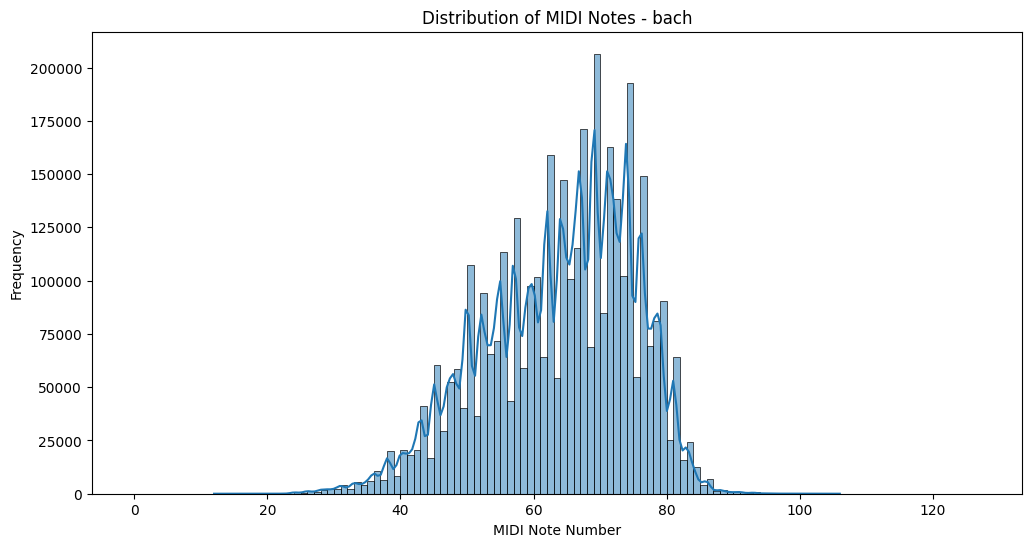

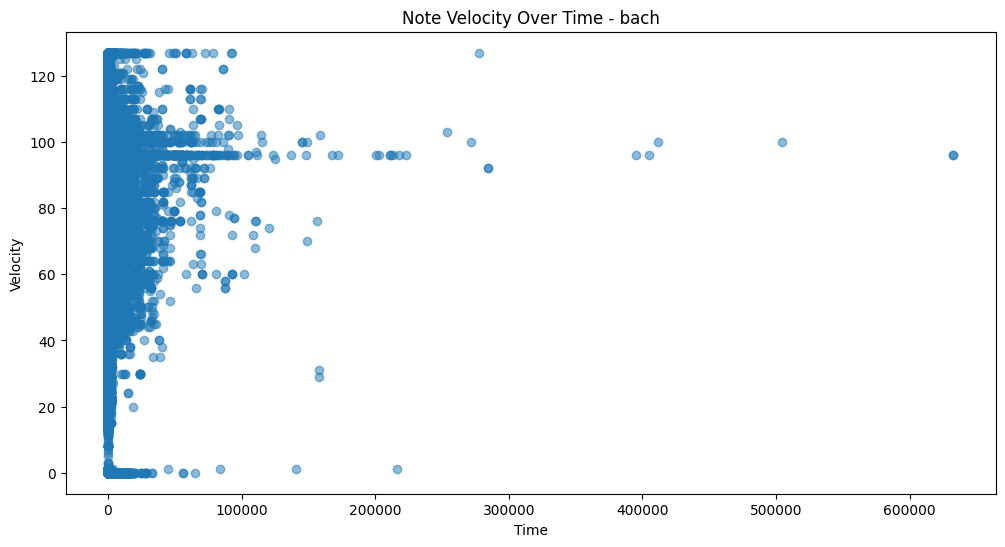

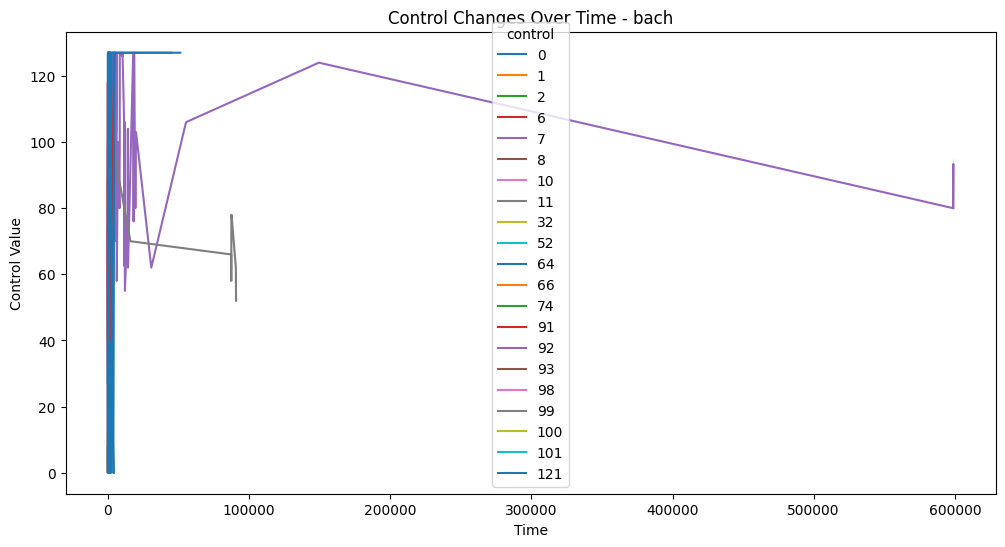

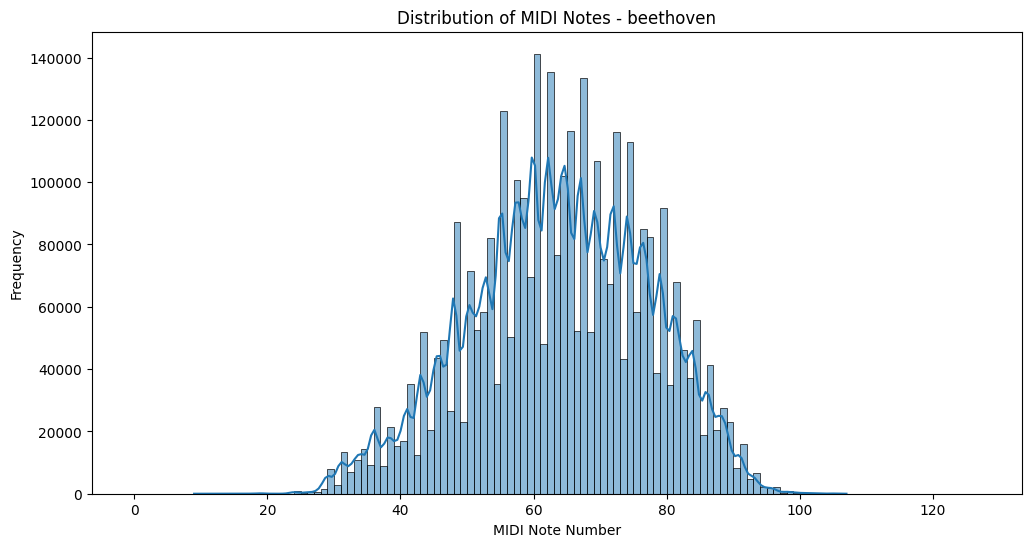

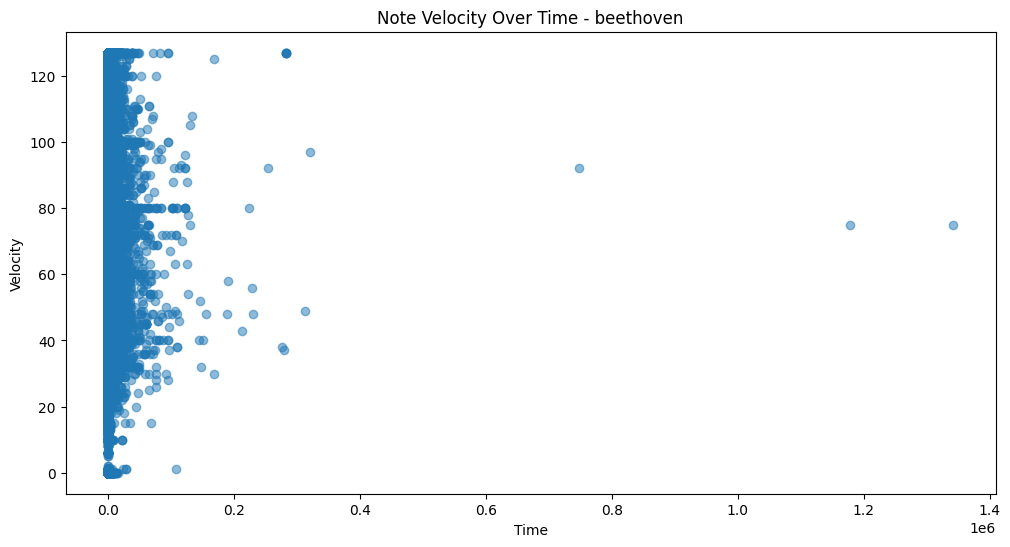

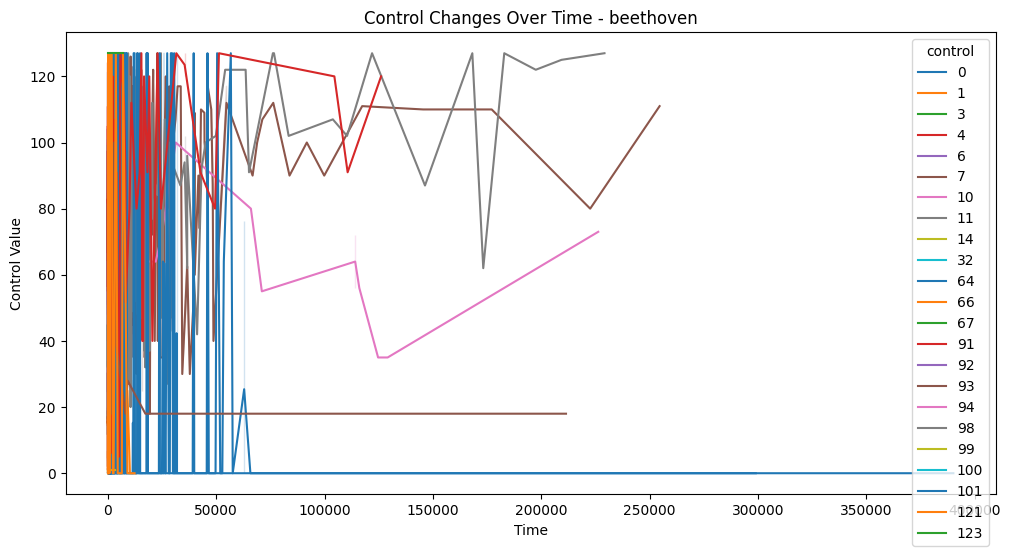

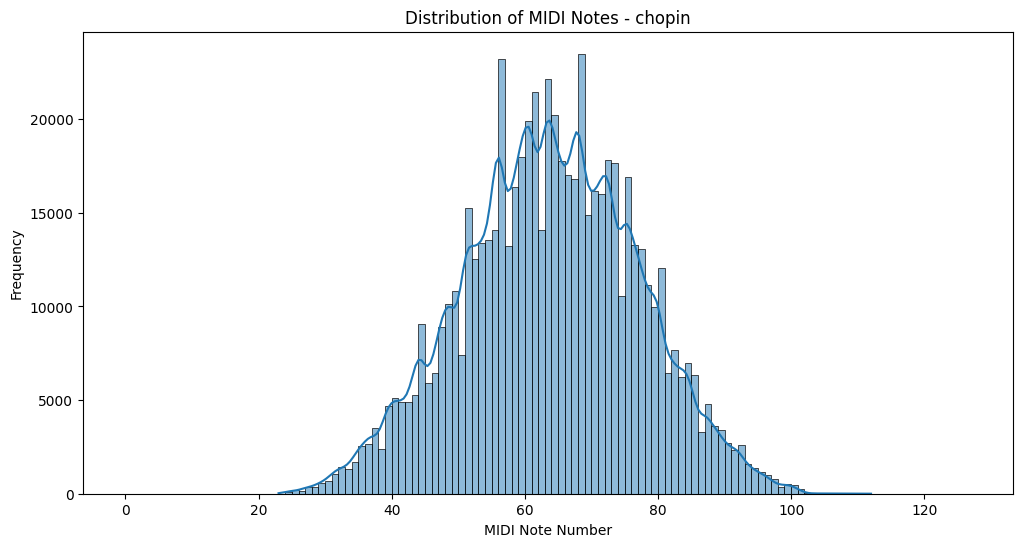

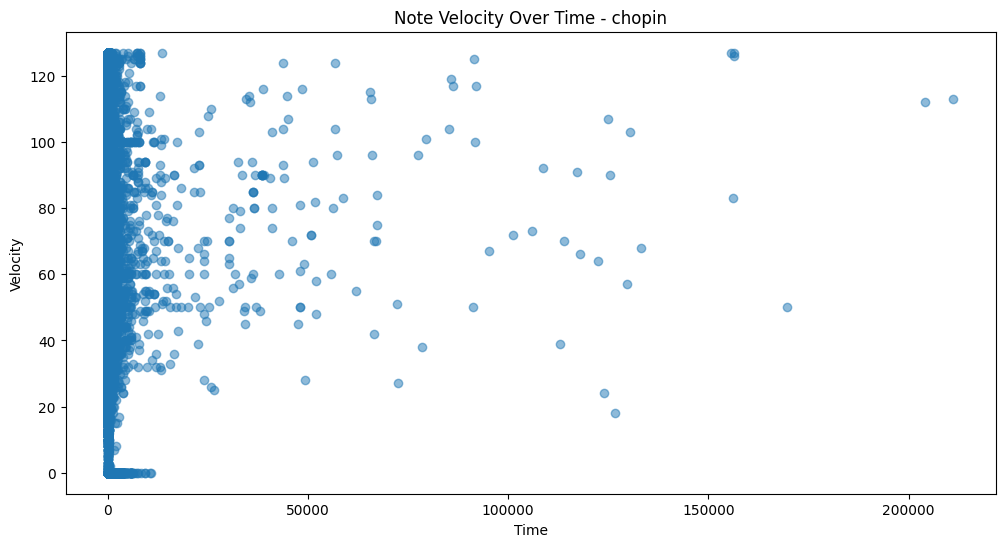

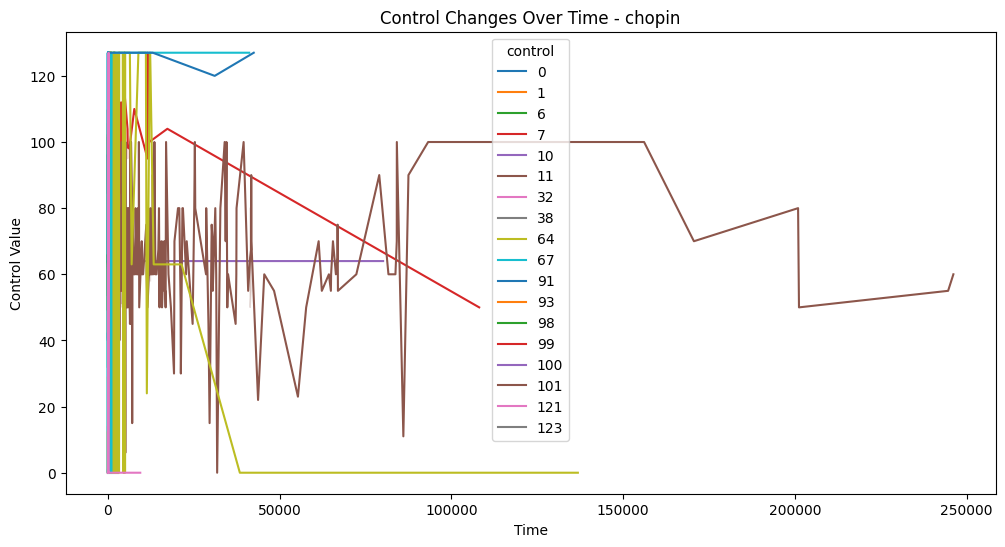

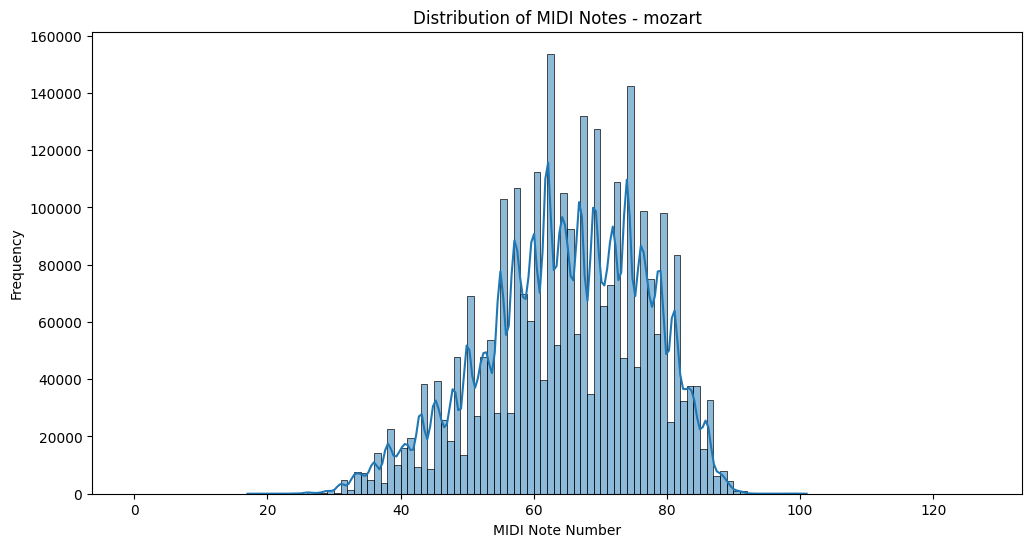

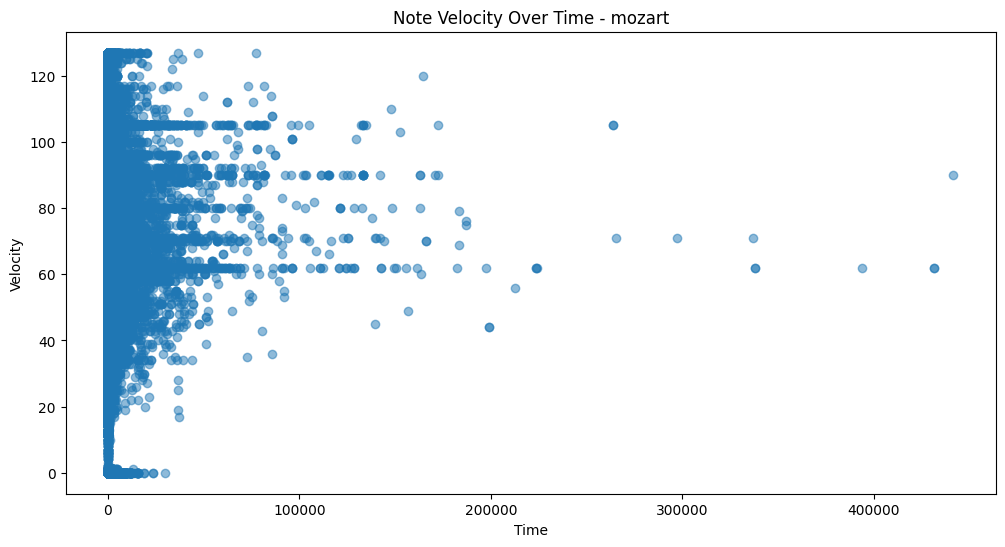

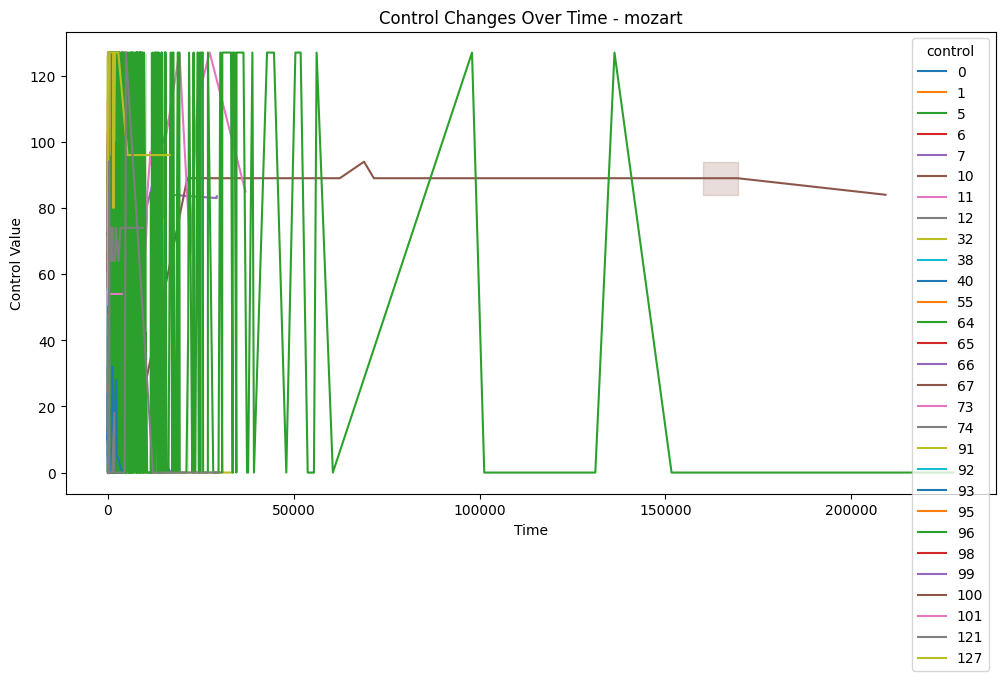

In [ ]:
# functions for pre processing data

def process_and_analyze_midi_files(artist_file_tuples):
    artist_dict = {}
    all_music_dict = {}

    for file_path, artist_name in artist_file_tuples:
      filename = os.path.basename(file_path)

      if artist_name not in artist_dict:
          artist_dict[artist_name] = []
          all_music_dict[artist_name] = []

      artist_dict[artist_name].append(file_path)

    for artist, paths in artist_dict.items():
      all_notes = []
      all_control_changes = []
      for path in paths:
        filename = os.path.basename(path)
        try:
            notes_df, control_changes_df = process_midi_file(path)
            notes_df['file'] = filename
            control_changes_df['file'] = filename
            all_notes.append(notes_df)
            all_control_changes.append(control_changes_df)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

        all_notes_df = pd.concat(all_notes, ignore_index=True)
        all_control_changes_df = pd.concat(all_control_changes, ignore_index=True)

      all_music_dict[artist].append((all_notes_df, all_control_changes_df))
      perform_eda(all_notes_df, all_control_changes_df, artist)

    return all_music_dict

def perform_eda(all_notes_df, all_control_changes_df, artist):

    plt.figure(figsize=(12, 6))
    sns.histplot(all_notes_df['note'], bins=range(0, 128), kde=True)
    plt.title(f'Distribution of MIDI Notes - {artist}')
    plt.xlabel('MIDI Note Number')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(all_notes_df['time'], all_notes_df['velocity'], alpha=0.5)
    plt.title(f'Note Velocity Over Time - {artist}')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=all_control_changes_df, x='time', y='value', hue='control', palette='tab10')
    plt.title(f'Control Changes Over Time - {artist}')
    plt.xlabel('Time')
    plt.ylabel('Control Value')
    plt.show()

def process_midi_file(file_path):
    midi_file = mido.MidiFile(file_path)
    notes = []
    control_changes = []

    for i, track in enumerate(midi_file.tracks):
        for msg in track:
            if msg.type == 'note_on' or msg.type == 'note_off':
                notes.append([msg.time, msg.type, msg.note, msg.velocity])
            elif msg.type == 'control_change':
                control_changes.append([msg.time, msg.control, msg.value])

    notes_df = pd.DataFrame(notes, columns=['time', 'type', 'note', 'velocity'])
    control_changes_df = pd.DataFrame(control_changes, columns=['time', 'control', 'value'])

    return notes_df, control_changes_df

artist_file_tuples = list(zip(midi_features_df['file_name'], midi_features_df['artist']))
all_music_dict = process_and_analyze_midi_files(artist_file_tuples)

In [ ]:
# print(all_music_dict['mozart'].keys())

# print("All notes dataframe for bach")
# display(all_music_dict['mozart']['unknown_artist-p_z-sonata_mozart.mid'][0].head())

# print("All control changes dataframe for bach")
# display(all_music_dict['mozart']['unknown_artist-p_z-sonata_mozart.mid'][1].head())

# len("total file count", len(artist_file_tuples[0][0]))
# for key in all_music_dict.keys():
#   print(f"All notes dataframe for {key}")
#   print("length of data", key, len(all_music_dict[key][0]))

display(all_music_dict['bach'][0][0].head())
display(all_music_dict['bach'][0][1].head())

# todo fix this, only have collected data for one file, need to bring back all
# maybe append to data frame as i'm processing it instead of keeping seperate dictionaries... maybe

,time,type,note,velocity,file
0,0,note_on,53,30,bach-avemaria.mid
1,48,note_off,53,30,bach-avemaria.mid
2,0,note_on,57,30,bach-avemaria.mid
3,48,note_off,57,30,bach-avemaria.mid
4,0,note_on,60,30,bach-avemaria.mid


,time,control,value,file
0,0,7,127,bach-bwv001-_400_chorales-066300b.mid
1,0,7,127,bach-bwv001-_400_chorales-066300b.mid
2,0,7,127,bach-bwv001-_400_chorales-066300b.mid
3,0,7,127,bach-bwv001-_400_chorales-066300b.mid
4,0,7,127,bach-bwv001-_400_chorales-066300b.mid


In [ ]:
# test train split

# # Reduce dimensionality
# midi_features_df['piano_roll_flat'] = midi_features_df['piano_roll'].apply(lambda x: np.array(x).flatten())

# # Combine piano_roll with other features
# X = np.hstack((np.stack(midi_features_df['piano_roll_flat'].values), midi_features_df.drop(columns=['artist', 'file_name', 'key_signature', 'piano_roll', 'piano_roll_flat']).values))

# # Encode the labels
# y = LabelEncoder().fit_transform(midi_features_df['artist'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Reduce dimensionality
midi_features_df['piano_roll_flat'] = midi_features_df['piano_roll'].apply(lambda x: np.array(x).flatten())

# Combine piano_roll with other features
X = np.hstack((np.stack(midi_features_df['piano_roll_flat'].values), midi_features_df.drop(columns=['artist', 'file_name', 'key_signature', 'piano_roll', 'piano_roll_flat']).values))

# Encode the labels
y = LabelEncoder().fit_transform(midi_features_df['artist'])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Handle missing values by imputing (replacing NaN with column mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data (X_train is still 2D here)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now reshape X_train_resampled back to 3D for the CNN-LSTM model
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)

# Reshape X_test for the CNN-LSTM model (no SMOTE applied to test data)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify the shapes after resampling and reshaping
print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")
print(f"Reshaped X_test shape: {X_test.shape}")


X shape: (1692, 134)
y shape: (1692,)
Resampled X_train shape: (3368, 134, 1)
y_train_resampled shape: (3368,)
Reshaped X_test shape: (339, 134, 1)


In [ ]:
# define model
def create_cnn_model_with_lstm(window_size=5, num_classes=4):
    print('Creating CNN model with LSTM...')

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model created successfully!")
    return model


In [ ]:
input_size = X_train.shape[1]

model = create_cnn_model_with_lstm(window_size=input_size, num_classes=len(y))

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size = 32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.evaluate(X_test, y_test)

Creating CNN model with LSTM...
Model created successfully!
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.0167 - loss: 7.3556 - val_accuracy: 0.5782 - val_loss: 7.1874
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6248 - loss: 7.1200 - val_accuracy: 0.6372 - val_loss: 6.8888
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6116 - loss: 6.7742 - val_accuracy: 0.6372 - val_loss: 6.3512
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6403 - loss: 6.2201 - val_accuracy: 0.6372 - val_loss: 5.8480
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6025 - loss: 5.7345 - val_accuracy: 0.6372 - val_loss: 5.2924
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6117 - loss: 5.1388 - val_accuracy: 0.6372 - val_loss: 4.5955
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6199 - loss: 4.4175 - val_accuracy: 0.6372 - val_loss: 3.8477
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38

[0.6147307753562927, 0.7758111953735352]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Predict on validation dataset
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
# Calculate metrics
val_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_test, y_pred, average='weighted')
val_f1 = f1_score(y_test, y_pred, average='weighted')
print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)
print('Validation F1 Score:', val_f1)

# Compute additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# Accuracy (can also be calculated separately)
accuracy = accuracy_score(y_test, y_pred)
print(f"Calculated Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Validation Precision: 0.6661091212994092
Validation Recall: 0.7404129793510325
Validation F1 Score: 0.697087365779739
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       216
           1       0.47      0.30      0.37        46
           2       0.00      0.00      0.00        30
           3       0.40      0.53      0.46        47

    accuracy                           0.74       339
   macro avg       0.43      0.45      0.44       339
weighted avg       0.67      0.74      0.70       339

Confusion Matrix:
[[212   0   0   4]
 [  8  14   0  24]
 [  5  16   0   9]
 [ 22   0   0  25]]
Calculated Accuracy: 0.7404129793510325


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


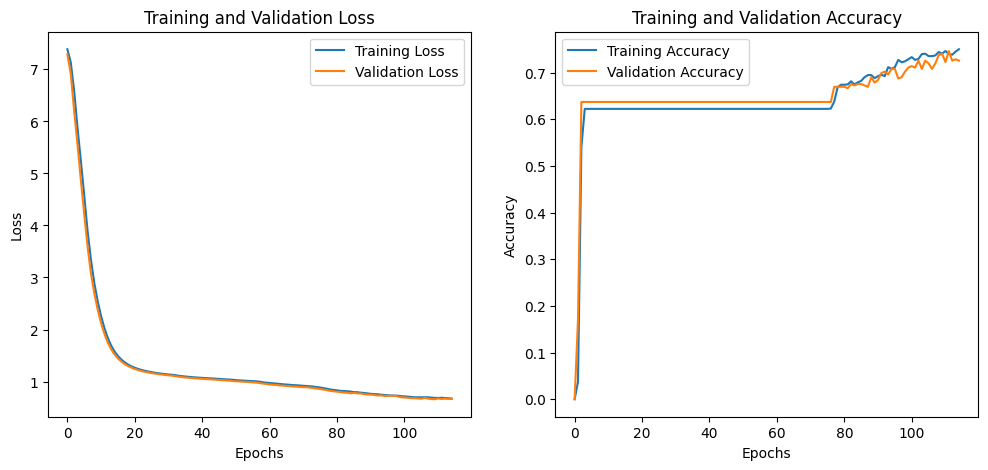

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
def create_rnn_model(window_size=5, num_classes=4):
    print('Creating RNN model...')

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.SimpleRNN(50, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model created successfully!")
    return model

model = create_rnn_model(window_size=input_size, num_classes=len(np.unique(y)))

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size = 32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.evaluate(X_test, y_test)

Creating RNN model...
Model created successfully!
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2656 - loss: 11.3047 - val_accuracy: 0.5752 - val_loss: 2.6337
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5113 - loss: 2.4254 - val_accuracy: 0.6077 - val_loss: 1.9997
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5681 - loss: 1.8931 - val_accuracy: 0.5959 - val_loss: 1.9327
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5768 - loss: 1.5875 - val_accuracy: 0.5841 - val_loss: 1.5924
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5557 - loss: 1.4853 - val_accuracy: 0.6047 - val_loss: 1.4408
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5771 - loss: 1.3843 - val_accuracy: 0.6283 - val_loss: 1.4583
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6076 - loss: 1.4816 - val_accuracy: 0.6460 - val_loss: 1.3617
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step -

[0.8204657435417175, 0.7079645991325378]

In [ ]:
def create_deep_cnn_lstm_model(window_size=5, num_classes=4):
    print('Creating deep CNN model with LSTM...')

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model created successfully!")
    return model

model = create_deep_cnn_lstm_model(window_size=input_size, num_classes=len(np.unique(y)))

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size = 32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.evaluate(X_test, y_test)

Creating deep CNN model with LSTM...
Model created successfully!
Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4860 - loss: 1.2882 - val_accuracy: 0.6372 - val_loss: 1.0787
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5957 - loss: 1.0932 - val_accuracy: 0.6372 - val_loss: 0.9770
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.6301 - loss: 0.9736 - val_accuracy: 0.6372 - val_loss: 0.8981
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5918 - loss: 0.9480 - val_accuracy: 0.6431 - val_loss: 0.8149
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6393 - loss: 0.8150 - val_accuracy: 0.6608 - val_loss: 0.7568
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6986 - loss: 0.7517 - val_accuracy: 0.7080 - val_loss: 0.7278
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6952 - loss: 0.7715 - val_accuracy: 0.7522 - val_loss: 0.6787
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━

[0.5617061853408813, 0.7964601516723633]